In [30]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Inputs

In [31]:
 
#labels
tags = []
tags = [
        'W(lv)Jets, background',
        'Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m',
        'W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m',
        'W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/'

# file names

fnames = {}

fnames['W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m'] = 'testrun/SusyLLP_x1n2-n1-wlv-hbb_mchi200_mlsp150_pl1000_ev100000.root'
fnames['Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] =  'testrun/SusyLLP_n3n2-n1-zll-hbb_mh200_pl1000_ev100000.root'
fnames['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 'testrun/SusyLLP_WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-1000.root' 
fnames['W(lv)Jets, background'] = 'testrun/SusyLLP_WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v6-v1_part.root'
# fnames['W(lv)Jets, background'] = 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v6-v1_v2_v1/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v6-v1_v2_v1_Job0_Of_5.root'

# output plots directory
out_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20191113/'

 
# colors
cols = {}

cols['W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m'] = 215 
cols['Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] = 207  
cols['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 221 
cols['W(lv)Jets, background'] = 209 


#styles
stys = {}

stys['W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m'] = 3 
stys['Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] = 4  
stys['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 2 
stys['W(lv)Jets, background'] = 1
 

# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])
 
    root_dir = uproot.open(home_dir+fnames[tag]) 
    tree[tag] = root_dir['SusyLLPTree']
 
    print ('Open ready')
    print(tag)
    print ('Tree ready') 
    print(tree[tag], tree)
    v = tree[tag]
#     llp_d_pid = v['gLLP_daughter_pid'].array()
#     print(llp_d_pid[:10])
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    if 'back' not in tag:
        calo_jet_amax = v['gLLP0_EB'].array()
        print(calo_jet_amax[:10])

/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/testrun/SusyLLP_WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v6-v1_part.root
Open ready
W(lv)Jets, background
Tree ready
<TTree b'SusyLLPTree' at 0x7fa4d45ae128> OrderedDict([('W(lv)Jets, background', <TTree b'SusyLLPTree' at 0x7fa4d45ae128>)])
[[0.53055966 0.19792055 0.15962103] [] [] ... [0.47920233 0.78783536] [0.17323194] []]
/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/testrun/SusyLLP_n3n2-n1-zll-hbb_mh200_pl1000_ev100000.root
Open ready
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7fa4d447e0b8> OrderedDict([('W(lv)Jets, background', <TTree b'SusyLLPTree' at 0x7fa4d45ae128>), ('Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m', <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>)])
[[0.01720145 0.110809505] [0.030581167 0.020538347 0.25503337] [0.021582091 0.054936707] ... [0.017149942 0.0480242 0.050478473] [0.29020783] [0.013071676 0.049307257 0.53833663 0.13096848]]
[False False Fa

In [32]:
import os

out_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/'

print(out_dir)
# os.mkdir(out_dir)


/storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/


## variables

In [33]:
# pf jet

trg_path = 310
# 310 HLT_PFMET120_PFMHT120_IDTight

met_cut = 50

met_den_all = {}
met_den_1 = {}
met_den_2 = {}
met_num_all = {}
met_num_1 = {}
met_num_2 = {}

for k,v in tree.items(): 
    print(k,v)
    
    met_den_all[k] = {}
    met_den_1[k] = {}
    met_den_1[k] = {}
    met_num_all[k] = {}
    met_num_1[k] = {}
    met_num_2[k] = {}
 
    #branches

    hlt = v['HLTDecision'].array()
    met = v['met'].array()
    
    acc0_eb = v['gLLP0_EB'].array()
    acc1_eb = v['gLLP1_EB'].array() 
    
    #acceptance requirement
    acc_eb_all_str = np.logical_or(acc0_eb==1, acc1_eb==1)
    
    acc_eb_llp0_str = np.logical_and(acc0_eb==1, acc1_eb==0)
    acc_eb_llp1_str = np.logical_and(acc0_eb==0, acc1_eb==1)
    acc_eb_1_str = np.logical_or(acc_eb_llp0_str,acc_eb_llp1_str)
    
    acc_eb_2_str = np.logical_and(acc0_eb==1, acc1_eb==1)
    
    if 'background' in k:
        acc_eb_all_str = 1
        acc_eb_1_str = 1
        acc_eb_2_str = 1
        
    acc_eb_all_str = np.logical_and(acc_eb_all_str, met>met_cut)
    acc_eb_1_str = np.logical_and(acc_eb_1_str, met>met_cut)
    acc_eb_2_str = np.logical_and(acc_eb_2_str, met>met_cut)

    # select only triggered events
#     print('trigger decision',hlt[:,310])
#     print('trigger shape',np.zeros(hlt[:,0].shape))
#     sel_hlt_triggered = np.zeros(hlt[:,0].shape)
    sel_hlt_triggered = 1
    sel_hlt_den  = np.logical_or(sel_hlt_triggered, hlt[:,trg_path])
    sel_hlt_num  = np.logical_and(sel_hlt_triggered, hlt[:,trg_path])
    
    # denominator string
    den_all_str = np.logical_and(acc_eb_all_str, sel_hlt_den)
    den_1_str = np.logical_and(acc_eb_1_str, sel_hlt_den)
    den_2_str = np.logical_and(acc_eb_2_str, sel_hlt_den)
    
    #numerator string
    num_all_str = np.logical_and(acc_eb_all_str, sel_hlt_num)
    num_1_str = np.logical_and(acc_eb_1_str, sel_hlt_num)
    num_2_str = np.logical_and(acc_eb_2_str, sel_hlt_num)
    
    # variables    
    den_all = met[den_all_str]
    den_1 = met[den_1_str]
    den_2 = met[den_2_str]
    
    num_all = met[num_all_str]
    num_1 = met[num_1_str]
    num_2 = met[num_2_str]
    
    #assign
    met_den_all[k] = den_all
    met_den_1[k] = den_1
    met_den_2[k] = den_2

    met_num_all[k] = num_all
    met_num_1[k] = num_1
    met_num_2[k] = num_2


W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>


## met distributions

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
[62.07413  50.804916 96.5455   59.85234  56.803513 61.682915 59.513794
 54.753723 73.32857  57.25253 ]
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
[ 84.68051  324.20978   53.69512  116.85786   55.41506   62.604618
 120.032326 265.45032  101.63223  128.61131 ]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
[ 57.49084   69.47395   61.005173  59.148594 110.87877  119.676865
  87.16095   82.79427  110.337814  65.32622 ]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>
[ 80.25797   52.87088   61.2114    51.471615  82.52351   63.8036
  85.04141   82.90565  189.7452    72.862656]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_den_all.png has been created


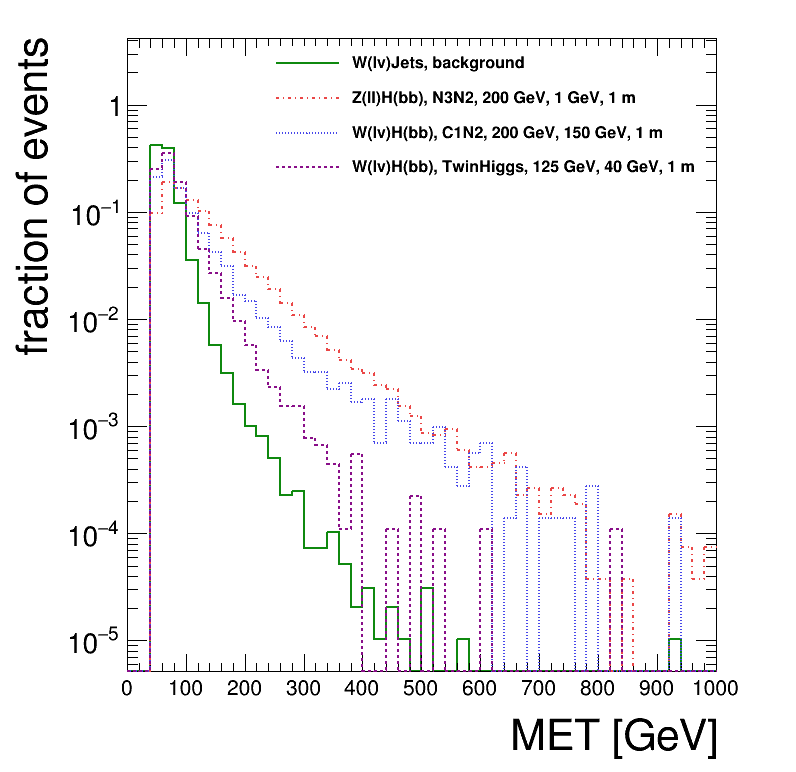

In [34]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = met_den_all[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
    ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met_den_all.png')

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
[62.07413  50.804916 96.5455   59.85234  56.803513 61.682915 59.513794
 54.753723 73.32857  57.25253 ]
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
[ 84.68051   53.69512   55.41506   62.604618 120.032326 265.45032
 128.61131   75.54108   58.617416 103.96501 ]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
[ 57.49084   69.47395   61.005173  59.148594 110.87877  119.676865
  87.16095   82.79427  110.337814  65.32622 ]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>
[ 80.25797   52.87088   61.2114    51.471615  82.52351   63.8036
  85.04141  189.7452    72.862656  57.321857]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_den_1.png has been created


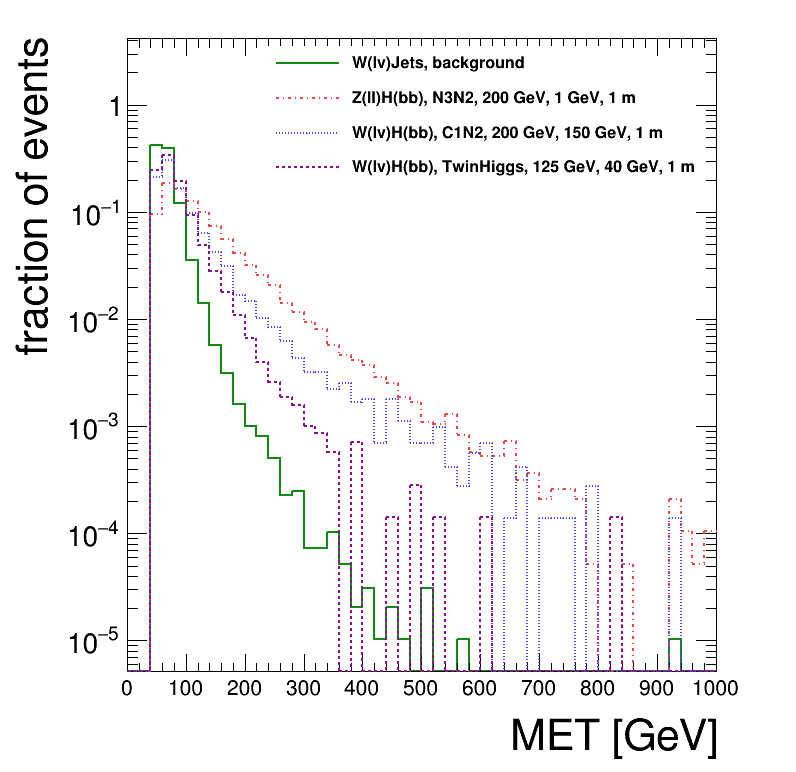

In [35]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = met_den_1[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
    ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met_den_1.png')

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
[62.07413  50.804916 96.5455   59.85234  56.803513 61.682915 59.513794
 54.753723 73.32857  57.25253 ]
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
[324.20978  116.85786  101.63223  525.3055   165.93231   65.2908
  99.29877  158.71532  102.081856 189.49585 ]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
[]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>
[ 82.90565   84.18358  133.88388   80.35381   77.422775  82.11314
  55.601875 100.56068   59.689095  52.35676 ]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: 
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_den_2.png has been created


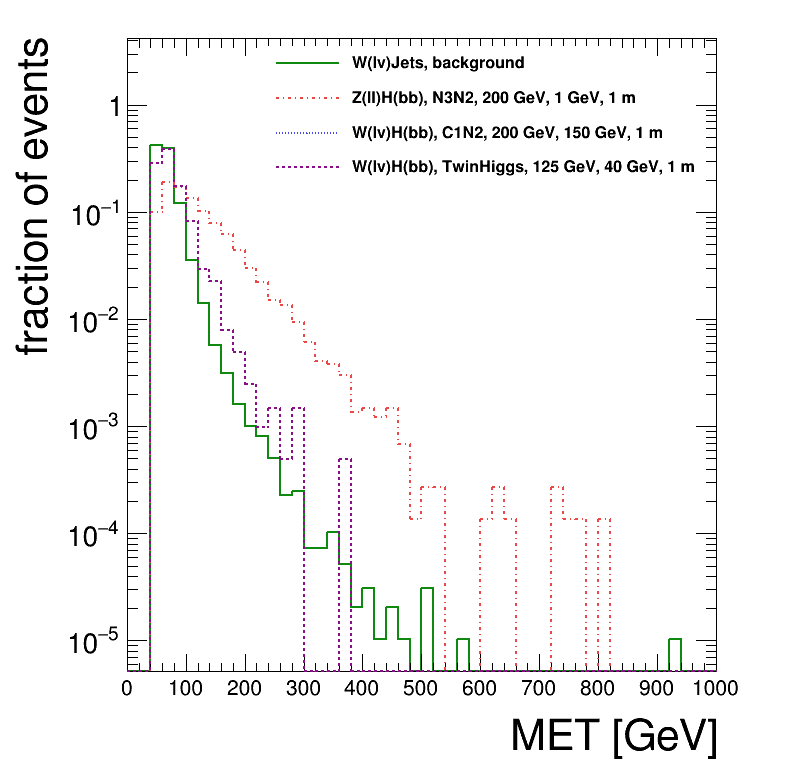

In [36]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = met_den_2[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
    ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met_den_2.png')

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
[115.352486 107.55708  202.31863  121.73668  118.62817  173.06291
 164.8649   194.43817  352.93817  112.909065]
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
[324.20978  116.85786  120.032326 128.61131  525.3055   165.93231
 158.71532  428.75623  203.14006  222.93777 ]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
[110.87877  119.676865 123.594696 132.55513  127.21251  171.87134
 461.0282   191.65231  183.10072  322.2791  ]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>
[189.7452   84.18358 157.78668 134.44121  93.64007 282.59042 184.4132
 137.8158  154.82979 181.98431]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_num_all.png has been created


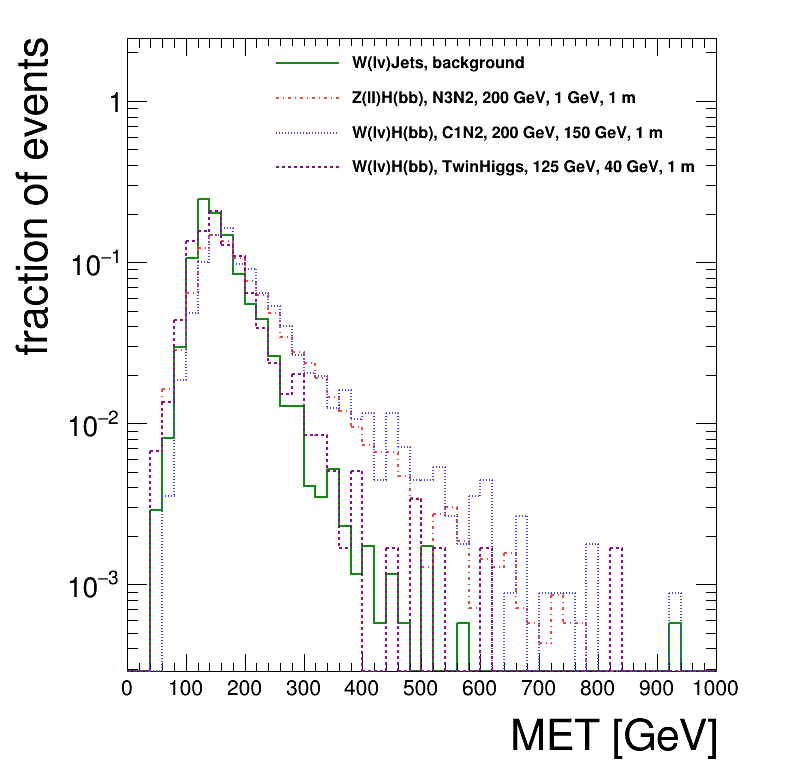

In [37]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)


    j_gamma_all = met_num_all[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
    ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met_num_all.png')

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
[115.352486 107.55708  202.31863  121.73668  118.62817  173.06291
 164.8649   194.43817  352.93817  112.909065]
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
[120.032326 128.61131  428.75623  203.14006  222.93777  151.63971
 184.86737  112.314896 217.00233   98.50514 ]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
[110.87877  119.676865 123.594696 132.55513  127.21251  171.87134
 461.0282   191.65231  183.10072  322.2791  ]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>
[189.7452  157.78668 134.44121  93.64007 282.59042 184.4132  137.8158
 154.82979 181.98431 194.34807]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_num_1.png has been created


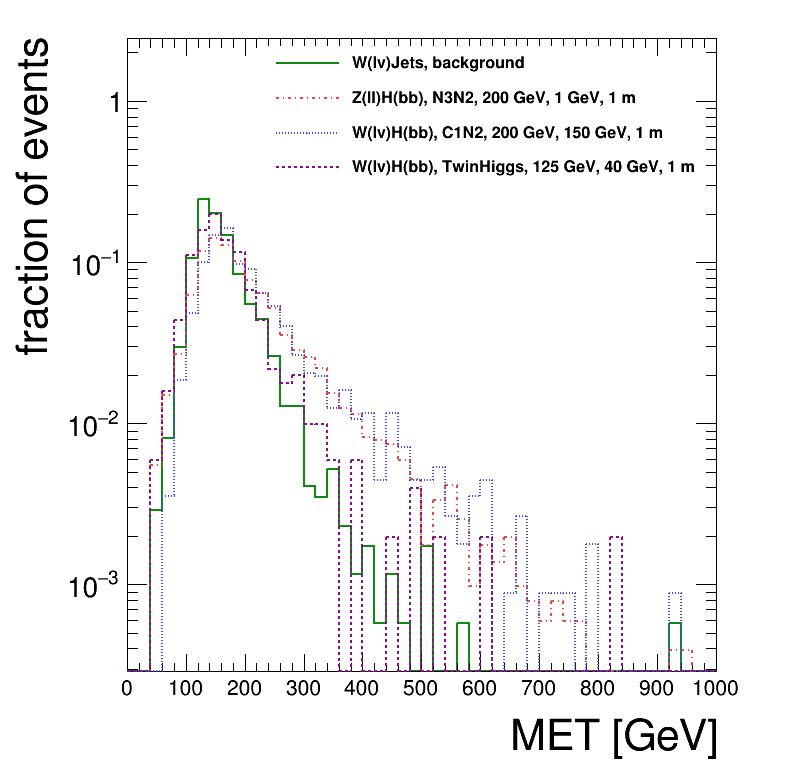

In [38]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)


    j_gamma_all = met_num_1[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
    ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met_num_1.png')

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
[115.352486 107.55708  202.31863  121.73668  118.62817  173.06291
 164.8649   194.43817  352.93817  112.909065]
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
[324.20978 116.85786 525.3055  165.93231 158.71532  90.96467 108.69109
 146.2068  249.9318  181.9392 ]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
[]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>
[ 84.18358  137.42732  211.51389  101.826164 192.2678   142.89441
 198.90646  142.94456  113.95799   90.677536]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: 
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_num_2.png has been created


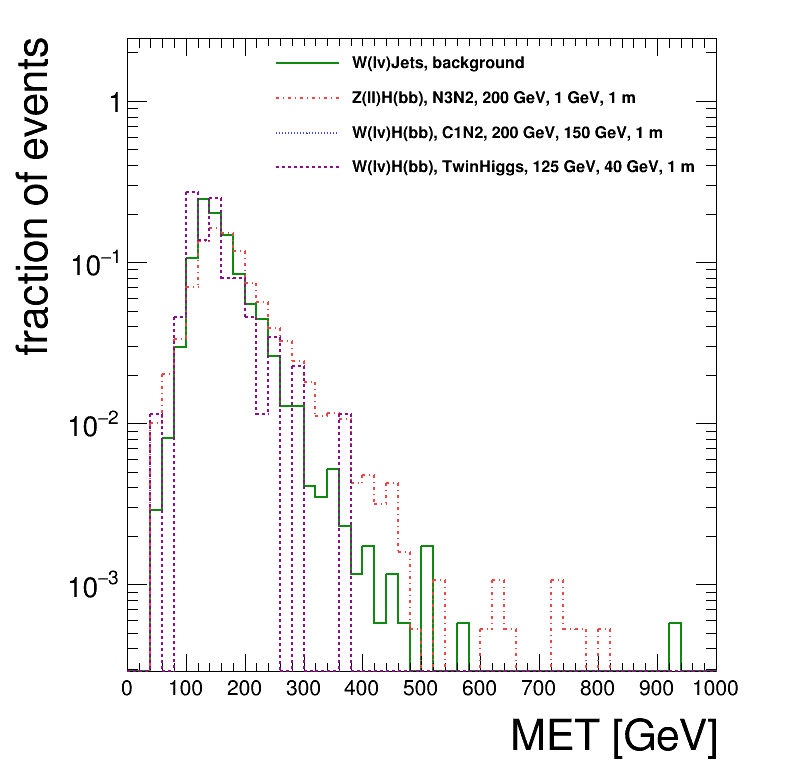

In [39]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)


    j_gamma_all = met_num_2[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
    ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met_num_2.png')

## num and den in one canvas

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_all_W(lv)Jets, background.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_all_Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_all_W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_all_W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m.png has been created


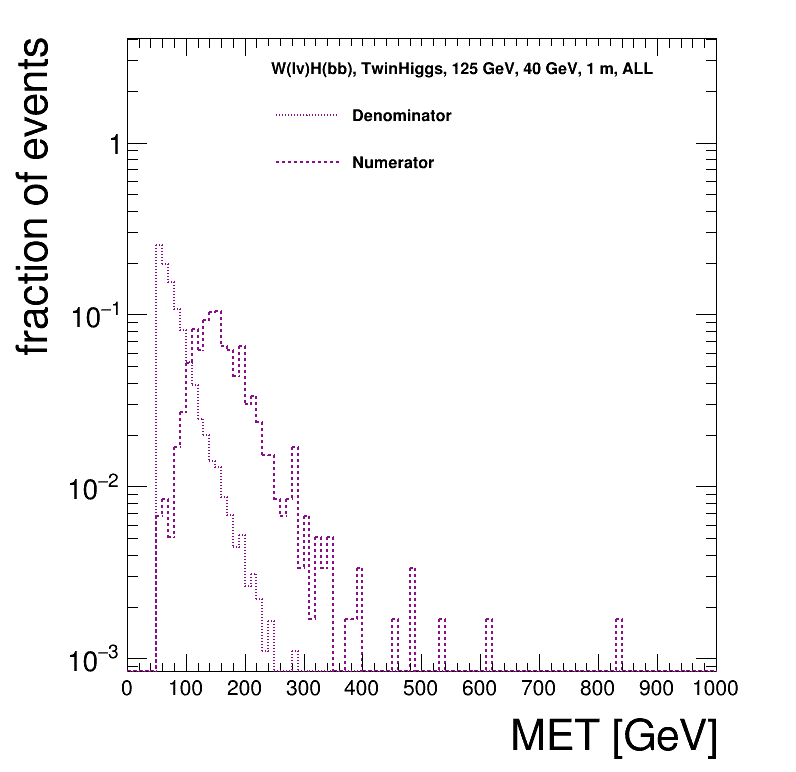

In [40]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
den_all = {}
num_all = {}

for k,v in tree.items(): 
    print(k,v)
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    met_num_all_h = met_num_all[k]
    
    met_den_all_h = met_den_all[k]

    den_all[k] = create_TH1D( met_den_all_h, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[100,-0,1000])
    den_all[k].SetLineStyle(stys[k]+1)
    den_all[k].SetLineColor(cols[k])
    den_all[k].SetMarkerColor(cols[k])
    den_all[k].GetXaxis().SetLabelSize(0.03)
    den_all[k].GetYaxis().SetLabelSize(0.04)
    den_all[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    num_all[k] = create_TH1D( met_num_all_h, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[100,-0,1000])
    num_all[k].SetLineStyle(stys[k])
    num_all[k].SetLineColor(cols[k])
    num_all[k].SetMarkerColor(cols[k])
    num_all[k].GetXaxis().SetLabelSize(0.03)
    num_all[k].GetYaxis().SetLabelSize(0.04)
    num_all[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    num_all[k].DrawNormalized('same')
    den_all[k].DrawNormalized('same')

    leg.SetHeader(k+', ALL')
    leg.AddEntry(den_all[k], 'Denominator')
    leg.AddEntry(num_all[k], 'Numerator')

    i += 1


    leg.Draw()

    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'met_all_'+k+'.png')

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_1_W(lv)Jets, background.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_1_Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_1_W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_1_W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m.png has been created


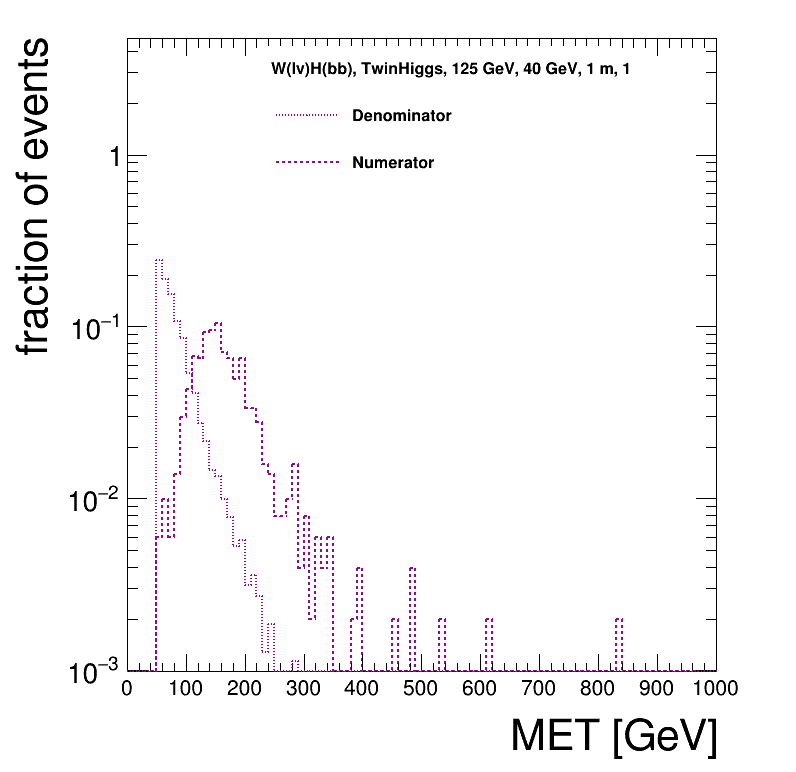

In [41]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
den_1 = {}
num_1 = {}

for k,v in tree.items(): 
    print(k,v)
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    met_num_1_h = met_num_1[k]
    
    met_den_1_h = met_den_1[k]

    den_1[k] = create_TH1D( met_den_1_h, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[100,-0,1000])
    den_1[k].SetLineStyle(stys[k]+1)
    den_1[k].SetLineColor(cols[k])
    den_1[k].SetMarkerColor(cols[k])
    den_1[k].GetXaxis().SetLabelSize(0.03)
    den_1[k].GetYaxis().SetLabelSize(0.04)
    den_1[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    num_1[k] = create_TH1D( met_num_1_h, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[100,-0,1000])
    num_1[k].SetLineStyle(stys[k])
    num_1[k].SetLineColor(cols[k])
    num_1[k].SetMarkerColor(cols[k])
    num_1[k].GetXaxis().SetLabelSize(0.03)
    num_1[k].GetYaxis().SetLabelSize(0.04)
    num_1[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    num_1[k].DrawNormalized('same')
    den_1[k].DrawNormalized('same')

    leg.SetHeader(k+', 1')
    leg.AddEntry(den_1[k], 'Denominator')
    leg.AddEntry(num_1[k], 'Numerator')

    i += 1


    leg.Draw()

    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'met_1_'+k+'.png')

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_2_W(lv)Jets, background.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_2_Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: 
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: 
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/met_2_W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/

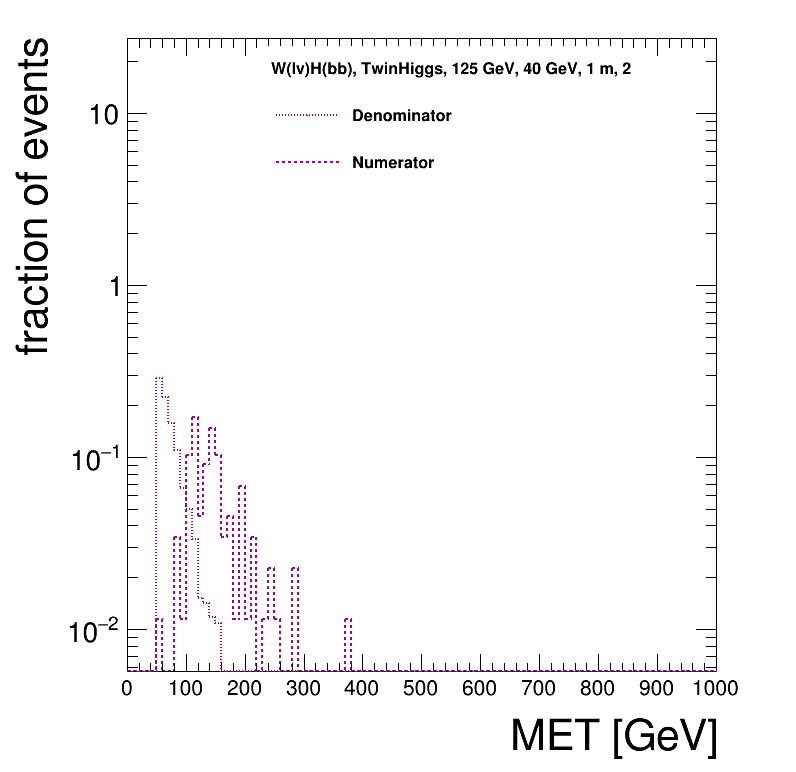

In [42]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
den_2 = {}
num_2 = {}

for k,v in tree.items(): 
    print(k,v)
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    met_num_2_h = met_num_2[k]
    
    met_den_2_h = met_den_2[k]

    den_2[k] = create_TH1D( met_den_2_h, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[100,-0,1000])
    den_2[k].SetLineStyle(stys[k]+1)
    den_2[k].SetLineColor(cols[k])
    den_2[k].SetMarkerColor(cols[k])
    den_2[k].GetXaxis().SetLabelSize(0.03)
    den_2[k].GetYaxis().SetLabelSize(0.04)
    den_2[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    num_2[k] = create_TH1D( met_num_2_h, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[100,-0,1000])
    num_2[k].SetLineStyle(stys[k])
    num_2[k].SetLineColor(cols[k])
    num_2[k].SetMarkerColor(cols[k])
    num_2[k].GetXaxis().SetLabelSize(0.03)
    num_2[k].GetYaxis().SetLabelSize(0.04)
    num_2[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    num_2[k].DrawNormalized('same')
    den_2[k].DrawNormalized('same')

    leg.SetHeader(k+', 2')
    leg.AddEntry(den_2[k], 'Denominator')
    leg.AddEntry(num_2[k], 'Numerator')

    i += 1


    leg.Draw()

    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'met_2_'+k+'.png')

## turn on

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_all_W(lv)Jets, background.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_all_Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_all_W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_all_W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m.png has been created


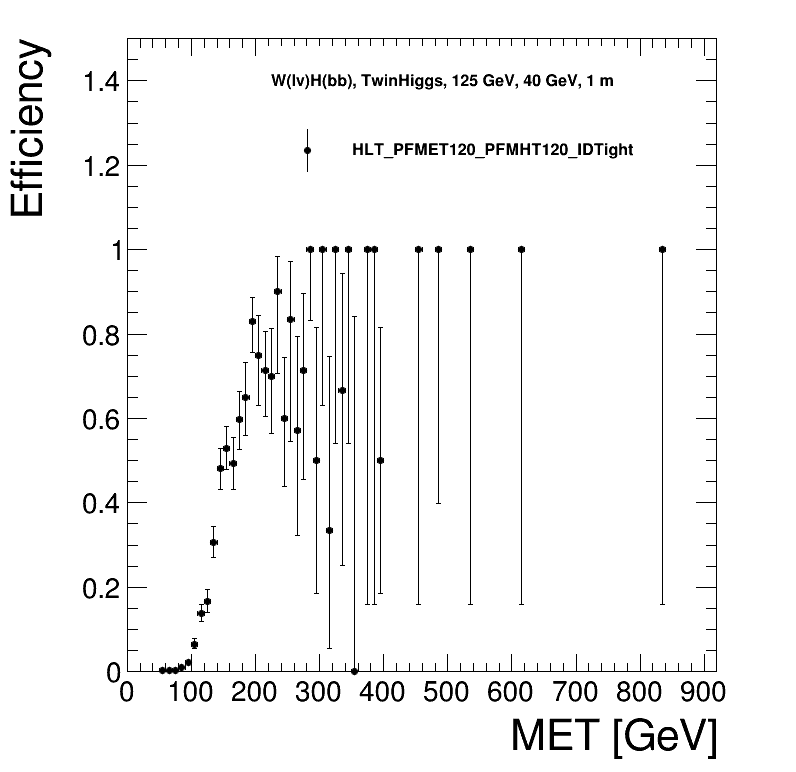

In [50]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
 

for k,v in tree.items(): 
    print(k,v)
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    
    pNum = num_all[k]
    pDen = den_all[k]
    
    #plot
    pEff = rt.TEfficiency(pNum, pDen)
    pEff.SetTitle("efficiency;MET [GeV];Efficiency")

    pEff.SetMarkerSize(0.8)
    pEff.SetMarkerStyle(20)
    pEff.Draw("apez")

    rt.gPad.Update()        
    #pEff.GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
    pEff.GetPaintedGraph().SetMarkerStyle(8)
    pEff.GetPaintedGraph().SetMarkerSize(20)        
    pEff.GetPaintedGraph().SetMinimum(0)
    pEff.GetPaintedGraph().SetMaximum(1.5)
    pEff.GetPaintedGraph().GetXaxis().SetLabelSize(0.04)
    pEff.GetPaintedGraph().GetYaxis().SetLabelSize(0.04)
    i += 1


    pEff.Draw()
    
    leg.SetHeader(k)
    leg.AddEntry(pEff, 'HLT_PFMET120_PFMHT120_IDTight', 'ep')
    
    leg.Draw()

#     c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'eff_met_all_'+k+'.png')

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_2_W(lv)Jets, background.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_2_Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_2_W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_2_W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m.png has been created


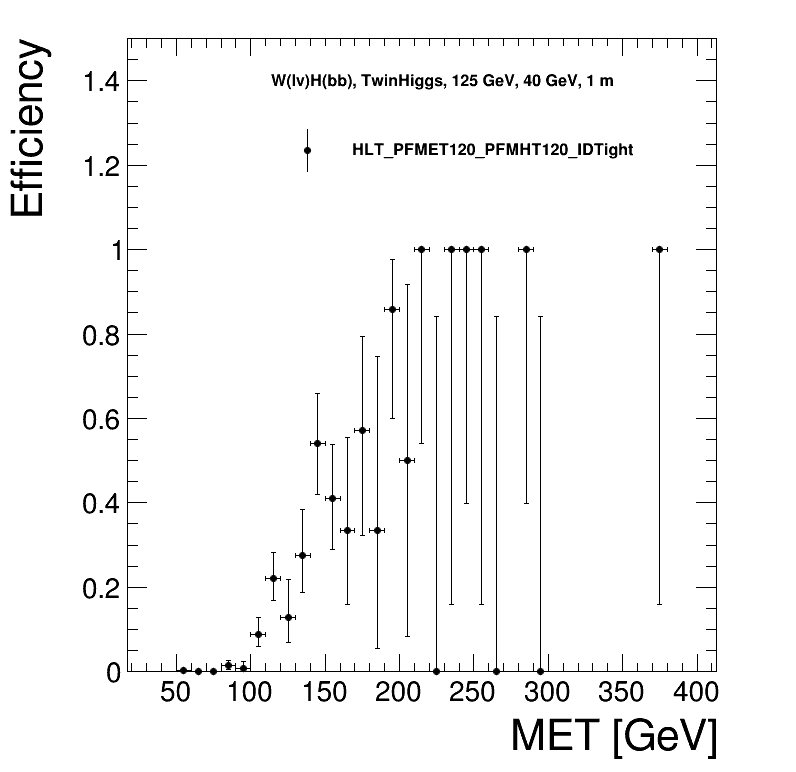

In [52]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
 

for k,v in tree.items(): 
    print(k,v)
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    pNum = num_2[k]
    pDen = den_2[k]
    
    #plot
    pEff = rt.TEfficiency(pNum, pDen)
    pEff.SetTitle("efficiency;MET [GeV];Efficiency")

    pEff.SetMarkerSize(0.8)
    pEff.SetMarkerStyle(20)
    pEff.Draw("apez")

    rt.gPad.Update()        
    #pEff.GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
    pEff.GetPaintedGraph().SetMarkerStyle(8)
    pEff.GetPaintedGraph().SetMarkerSize(20)        
    pEff.GetPaintedGraph().SetMinimum(0)
    pEff.GetPaintedGraph().SetMaximum(1.5)
    pEff.GetPaintedGraph().GetXaxis().SetLabelSize(0.04)
    pEff.GetPaintedGraph().GetYaxis().SetLabelSize(0.04)
    i += 1


    pEff.Draw()
    
    leg.SetHeader(k)
    leg.AddEntry(pEff, 'HLT_PFMET120_PFMHT120_IDTight', 'ep')
    
    leg.Draw()

#     c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'eff_met_2_'+k+'.png')

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fa4d45ae128>
Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa4d447e0b8>
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa5293526d8>
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fa529283550>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_1_W(lv)Jets, background.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_1_Z(ll)H(bb), N3N2, 200 GeV, 1 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_1_W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191125/eff_met_1_W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m.png has been created


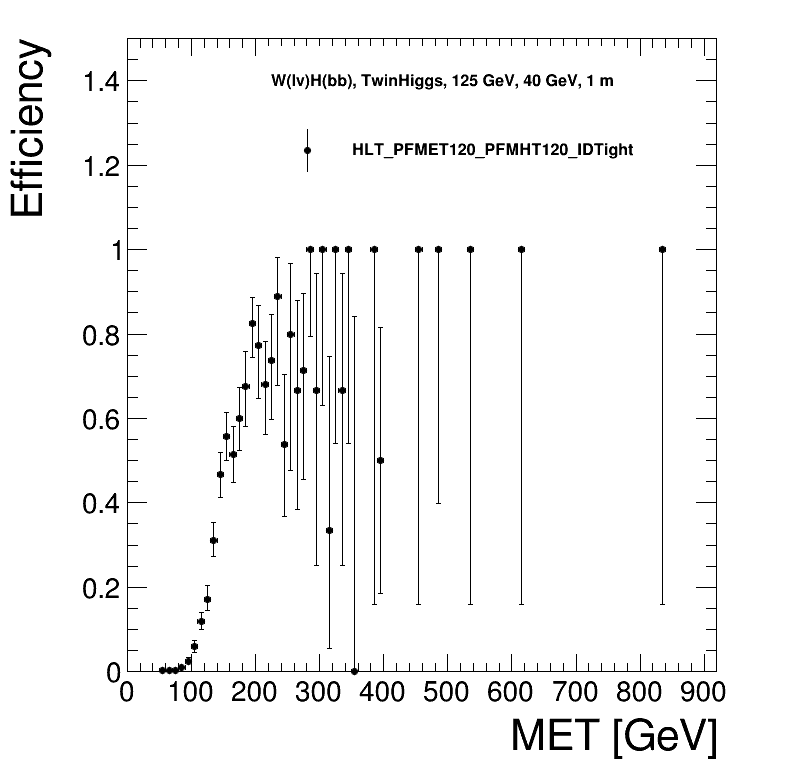

In [51]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
 

for k,v in tree.items(): 
    print(k,v)
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    pNum = num_1[k]
    pDen = den_1[k]
    
    #plot
    pEff = rt.TEfficiency(pNum, pDen)
    pEff.SetTitle("efficiency;MET [GeV];Efficiency")

    pEff.SetMarkerSize(0.8)
    pEff.SetMarkerStyle(20)
    pEff.Draw("apez")

    rt.gPad.Update()        
    #pEff.GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
    pEff.GetPaintedGraph().SetMarkerStyle(8)
    pEff.GetPaintedGraph().SetMarkerSize(20)        
    pEff.GetPaintedGraph().SetMinimum(0)
    pEff.GetPaintedGraph().SetMaximum(1.5)
    pEff.GetPaintedGraph().GetXaxis().SetLabelSize(0.04)
    pEff.GetPaintedGraph().GetYaxis().SetLabelSize(0.04)
    i += 1


    pEff.Draw()
    
    leg.SetHeader(k)
    leg.AddEntry(pEff, 'HLT_PFMET120_PFMHT120_IDTight', 'ep')
    
    leg.Draw()

#     c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'eff_met_1_'+k+'.png')